In [1]:
%reset
import sys, os
# import numpyro
# numpyro.set_host_device_count(4)
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from jax.lib import xla_bridge
platform = xla_bridge.get_backend().platform
import jax
jax.config.update('jax_platform_name', platform)
jax.config.update("jax_enable_x64", True)
import jax
# Change the current working directory to the desired path
# os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
sys.path.append('/mnt/home/spandey/ceph/GODMAX/src/')
from jax import config
config.update("jax_enable_x64", True)

# from jax import config
# config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




/tmp/ipykernel_2835857/1457169948.py:9: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  platform = xla_bridge.get_backend().platform


In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.29, 'Ob0': 0.049, 'sigma8': 0.783, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 2.75
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 14.83
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 32
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 3.0, 20
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
# halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 12.0, 15.5, 20
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 9, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**14, 32
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
# halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['conc_model'] = 'Duffy08'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/anvil/projects/x-phy240043/x-spandey3/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
# nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/anvil/projects/x-phy240043/x-spandey3/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['xip'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = True
analysis_dict['conc_dep_model'] = False

other_params_dict = {}
other_params_dict['A_IA'] = 0.01
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_rhocrit'] = 0.0134
other_params_dict['Delta_z_bias_array'] = np.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = np.zeros(nz_info_dict['nbins'])



In [3]:
import scipy.interpolate as interp
import pickle as pk
# df_measure = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/DESxACT_gty_xip_xim_DV_ilc_SZ_yy.pk', 'rb'))
df_measure = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/DESxACT_gty_xip_xim_DV_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy.pk', 'rb'))
cov_total = df_measure['cov_total']
xi_all = df_measure['xi_all']
cov_total = jnp.array(cov_total)
data_vec = jnp.array(xi_all)

# probe = 'xip_xim' 
# probe = 'gty'
probe = 'all'



if probe == 'xip_xim':
    cov_total = cov_total[80:, 80:]
    data_vec = data_vec[80:]
elif probe == 'gty':
    cov_total = cov_total[:80, :80]
    data_vec = data_vec[:80]

P_total = jnp.linalg.inv(cov_total)


# cov_gty = cov_total[0:80,0:80]
# C = jnp.array(df_data['COVMAT'].data[400:,400:])
# gty_data_to_plot = df_measure['xi_all'][60:80]
# gty_sig_to_plot = jnp.sqrt(jnp.diag(cov_gty))[60:80]

# C = cov_total[80:280,80:280]
# bin1, bin2 = df_measure['bin1_all'][80:280], df_measure['bin2_all'][80:280]
# indsel = np.where((bin1==4) & (bin2==4))[0]
# xip_data_to_plot = df_measure['xi_all'][80:280][indsel]
# xip_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]

# C = cov_total[280:480,280:480]
# bin1, bin2 = df_measure['bin1_all'][280:480], df_measure['bin2_all'][280:480]
# indsel = np.where((bin1==4) & (bin2==4))[0]
# xim_data_to_plot = df_measure['xi_all'][280:480][indsel]
# xim_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]







In [4]:
from numpyro.distributions.transforms import AffineTransform
import numpyro.distributions as dist
import numpyro
def Uniform(name, min_value, max_value):
    """ Creates a Uniform distribution in target range from a base
    distribution between [-3, 3]
    """
    s = (max_value - min_value) / 6.
    return numpyro.sample(
            name,
            dist.TransformedDistribution(
                dist.Uniform(-3., 3.),
                AffineTransform(min_value + 3.*s, s),
            ),
        )



/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df_cs = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits') 
bin1_vals =  df_cs['xip'].data['BIN1'][::20]
bin2_vals =  df_cs['xip'].data['BIN2'][::20]
biny_vals = np.array([1,2,3,4])

# index_gty = {}
index_gty = []
for js in range(80):
    # index_gty[js] = [js%20 ,js//20]
    index_gty.append([js%20 ,js//20])
index_gty = jnp.array(index_gty)
# index_xip = {}
index_xip = []
for js in range(200):
    binv = js//20
    thetav = js%20
    # index_xip[js] = [thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1]
    index_xip.append([thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1])
index_xip = jnp.array(index_xip)
# index_xim = {}
index_xim = []
for js in range(200):
    binv = js//20
    thetav = js%20
    # index_xim[js] = [thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1]   
    index_xim.append([thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1])
index_xim = jnp.array(index_xim)



In [6]:
prior_min_all_dict = {}
prior_max_all_dict = {}
prior_min_all_dict['Om0'] = 0.1
prior_max_all_dict['Om0'] = 0.5
prior_min_all_dict['Ob0'] = 0.03
prior_max_all_dict['Ob0'] = 0.07
prior_min_all_dict['h'] = 0.5
prior_max_all_dict['h'] = 0.9
prior_min_all_dict['ns'] = 0.8
prior_max_all_dict['ns'] = 1.2
prior_min_all_dict['sigma8'] = 0.6
prior_max_all_dict['sigma8'] = 1.0

prior_min_all_dict['theta_ej_0'] = 1.0
prior_max_all_dict['theta_ej_0'] = 5.0
prior_min_all_dict['log10_Mc0'] = 13.0
prior_max_all_dict['log10_Mc0'] = 15.0
prior_min_all_dict['nu_theta_ej_M'] = -3.0
prior_max_all_dict['nu_theta_ej_M'] = 0.0
prior_min_all_dict['nu_theta_ej_z'] = -2.0
prior_max_all_dict['nu_theta_ej_z'] = 2.0
prior_min_all_dict['alpha_nt'] = 0.0
prior_max_all_dict['alpha_nt'] = 0.4

prior_min_all_dict['A_IA'] = -3.0
prior_max_all_dict['A_IA'] = 3.0
prior_min_all_dict['eta_IA'] = -2.0
prior_max_all_dict['eta_IA'] = 2.0

prior_mu_all_dict = {}
prior_sig_all_dict = {}
prior_mu_all_dict['Delta_z_bias_bin1'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin1'] = 1.8e-2
prior_mu_all_dict['Delta_z_bias_bin2'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin2'] = 1.5e-2
prior_mu_all_dict['Delta_z_bias_bin3'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin3'] = 1.1e-2
prior_mu_all_dict['Delta_z_bias_bin4'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin4'] = 1.7e-2

prior_mu_all_dict['mult_shear_bias_bin1'] = -6e-3
prior_sig_all_dict['mult_shear_bias_bin1'] = 9e-3
prior_mu_all_dict['mult_shear_bias_bin2'] = -2e-2
prior_sig_all_dict['mult_shear_bias_bin2'] = 8e-3
prior_mu_all_dict['mult_shear_bias_bin3'] = -2.4e-2
prior_sig_all_dict['mult_shear_bias_bin3'] = 8e-3
prior_mu_all_dict['mult_shear_bias_bin4'] = -3.7e-2
prior_sig_all_dict['mult_shear_bias_bin4'] = 8e-3

prior_delta_z_mu_all = jnp.array([prior_mu_all_dict['Delta_z_bias_bin1'], prior_mu_all_dict['Delta_z_bias_bin2'], prior_mu_all_dict['Delta_z_bias_bin3'], prior_mu_all_dict['Delta_z_bias_bin4']])
prior_delta_z_sig_all = jnp.array([prior_sig_all_dict['Delta_z_bias_bin1'], prior_sig_all_dict['Delta_z_bias_bin2'], prior_sig_all_dict['Delta_z_bias_bin3'], prior_sig_all_dict['Delta_z_bias_bin4']])

prior_mult_shear_mu_all = jnp.array([prior_mu_all_dict['mult_shear_bias_bin1'], prior_mu_all_dict['mult_shear_bias_bin2'], prior_mu_all_dict['mult_shear_bias_bin3'], prior_mu_all_dict['mult_shear_bias_bin4']])
prior_mult_shear_sig_all = jnp.array([prior_sig_all_dict['mult_shear_bias_bin1'], prior_sig_all_dict['mult_shear_bias_bin2'], prior_sig_all_dict['mult_shear_bias_bin3'], prior_sig_all_dict['mult_shear_bias_bin4']])

# cosmo_params_vary_names = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
# sims_params_vary_names = ['theta_ej_0','log10_Mc0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'alpha_nt']
# IA_params_vary_names = ['A_IA', 'eta_IA']
# mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4'] 
# Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4']

# 'H0': 67.2, 'Om0': 0.29, 'Ob0': 0.049, 'sigma8': 0.783, 'ns': 0.95
cosmo_params_vary_names = ['Om0', 'sigma8', 'Ob0', 'h', 'ns']
sims_params_vary_names = ['theta_ej_0', 'nu_theta_ej_M', 'nu_theta_ej_z']
# sims_params_vary_names = []
# cosmo_params_vary_names = []
IA_params_vary_names = ['A_IA', 'eta_IA']
# IA_params_vary_names = ['eta_IA']
# IA_params_vary_names = []

mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4'] 
Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4']

# prior_delta_z_mu_all = []
# prior_delta_z_sig_all = []

# prior_mult_shear_mu_all = []
# prior_mult_shear_sig_all = []



In [7]:
# prior_delta_z_mu_all, prior_delta_z_sig_all
prior_mult_shear_mu_all, prior_mult_shear_sig_all


(Array([-0.006, -0.02 , -0.024, -0.037], dtype=float64),
 Array([0.009, 0.008, 0.008, 0.008], dtype=float64))

In [8]:
from get_corr_func_jit import get_corrfunc_BCMP
import numpyro
import copy

def model():
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    if len(cosmo_params_vary_names) > 0:
        for jp in range(len(cosmo_params_vary_names)):
            if cosmo_params_vary_names[jp] == 'h':
                fac = 100.
                cosmo_name = 'H0'
            else:
                fac = 1.
                cosmo_name = cosmo_params_vary_names[jp]
            prior_min_jp = prior_min_all_dict[cosmo_params_vary_names[jp]]
            prior_max_jp = prior_max_all_dict[cosmo_params_vary_names[jp]]
            sim_params_dict_vary['cosmo'][cosmo_name] = fac * Uniform(cosmo_params_vary_names[jp], prior_min_jp, prior_max_jp)

    if len(sims_params_vary_names) > 0:
        for jp in range(len(sims_params_vary_names)):
            prior_min_jp = prior_min_all_dict[sims_params_vary_names[jp]]
            prior_max_jp = prior_max_all_dict[sims_params_vary_names[jp]]
            sim_params_dict_vary[sims_params_vary_names[jp]] = Uniform(sims_params_vary_names[jp], prior_min_jp, prior_max_jp)
    
    if len(IA_params_vary_names) > 0:
        for jp in range(len(IA_params_vary_names)):
            prior_min_jp = prior_min_all_dict[IA_params_vary_names[jp]]
            prior_max_jp = prior_max_all_dict[IA_params_vary_names[jp]]
            other_params_dict_vary[IA_params_vary_names[jp]] = Uniform(IA_params_vary_names[jp], prior_min_jp, prior_max_jp)
        
    if len(prior_delta_z_mu_all) > 0:
        Delta_z_bias_array = numpyro.sample('Delta_z_bias_array', dist.Normal(prior_delta_z_mu_all, prior_delta_z_sig_all)) 
        other_params_dict_vary['Delta_z_bias_array'] = Delta_z_bias_array
    
    if len(prior_mult_shear_mu_all) > 0:
        mult_shear_bias_array = numpyro.sample('mult_shear_bias_array', dist.Normal(prior_mult_shear_mu_all, prior_mult_shear_sig_all))
        other_params_dict_vary['mult_shear_bias_array'] = mult_shear_bias_array
        
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False, num_points_trapz_int=32)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(80))
    xip_val = vmap(get_xip_from_index)(np.arange(200))
    xim_val = vmap(get_xim_from_index)(np.arange(200))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])
    # print(mu.shape, P_total.shape, cov_total.shape)
    return numpyro.sample('cl', dist.MultivariateNormal(mu, 
                                                        precision_matrix=P_total,
                                                        covariance_matrix=cov_total))





In [9]:
# # model()
# get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, verbose_time=False, num_points_trapz_int=32)

# def get_gty_from_index(index):
#     index_val = index_gty[index]
#     return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

# def get_xip_from_index(index):
#     index_val = index_xip[index]
#     return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

# def get_xim_from_index(index):
#     index_val = index_xim[index]
#     return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

# gty_val = vmap(get_gty_from_index)(np.arange(80))
# xip_val = vmap(get_xip_from_index)(np.arange(200))
# xim_val = vmap(get_xim_from_index)(np.arange(200))

# if probe == 'xip_xim':
#     mu = jnp.concatenate([xip_val, xim_val])
# elif probe == 'gty':
#     mu = gty_val
# else:
#     mu = jnp.concatenate([gty_val, xip_val, xim_val])
# print(mu.shape, P_total.shape, cov_total.shape)




In [10]:
# # dist.MultivariateNormal(mu, covariance_matrix=cov_total).sample(jax.random.PRNGKey(0))[0:80]
# # dist.MultivariateNormal(mu, covariance_matrix=cov_total).sample(jax.random.PRNGKey(0))[80:280]
# # dist.MultivariateNormal(mu[80:280], covariance_matrix=cov_total[80:280,:][:,80:280]).sample(jax.random.PRNGKey(0))
# # dist.MultivariateNormal(mu[:280], covariance_matrix=cov_total[:280,:][:,:280]).sample(jax.random.PRNGKey(0))[80:280]
# # np.linalg.cond(cov_total[80:280,:][:,80:280]), np.linalg.cond(cov_total[:80,:][:,:80]), np.linalg.cond(cov_total[:280,:][:,:280])
# # mu
# # pl.figure()
# # pl.errorbar(np.arange(len(mu)), mu, np.sqrt(np.diag(cov_total)), fmt='o', ms=0.1)
# # pl.yscale('log')
# pl.figure()
# # pl.imshow(np.log(np.abs(cov_total)), cmap='inferno', origin='lower')
# # pl.imshow(np.log(np.abs(cov_total[80:280,0:80])), cmap='inferno', origin='lower')
# # pl.imshow(np.log(np.abs(cov_total[80:100,0:20])), origin='lower')
# # pl.imshow(((cov_total[80:100,0:20])), origin='lower')
# pl.imshow(((cov_total[60:80,260:280])), origin='lower')
# pl.colorbar()
# # np.where(cov_total < 0)




In [11]:
import numpyro
numpyro.set_host_device_count(4)
from numpyro.handlers import seed, trace, condition
# Now we condition the model on obervations
observed_model = condition(model, {'cl': data_vec})



In [12]:
import numpyro
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)




In [13]:
from numpyro.infer import HMC, HMCECS, MCMC, NUTS, SA, SVI, Trace_ELBO, init_to_value
nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
                            step_size=1e-1, 
                            init_strategy=numpyro.infer.init_to_median,
                            dense_mass=False,
                            max_tree_depth=4)


# step_size = jnp.sqrt(0.5 / features.shape[0])
# trajectory_length = step_size * args.num_steps
# nuts_kernel = HMC(
#     model,
#     step_size=1e-1, 
#     trajectory_length=4,
#     adapt_step_size=False,
#     dense_mass=False
# )


In [14]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=500, 
                          num_samples=5000,
                          num_chains=2,
                          chain_method='vectorized',
                        #   chain_method='sequential',                          
                          progress_bar=True,
                          jit_model_args=True)




In [15]:
# !pip uninstall -y mcfit 
numpyro.set_platform("gpu")



In [16]:
import jax

mcmc.run(jax.random.PRNGKey(42))




sample: 100%|██████████| 5500/5500 [1:54:47<00:00,  1.25s/it]


In [17]:
s = mcmc.get_samples()


In [18]:
import pickle as pk
# saved = 

pk.dump(s, open('mcmc_gty_xip_xim_5000_500_num_chains_2.pkl', 'wb'))


/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (10000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


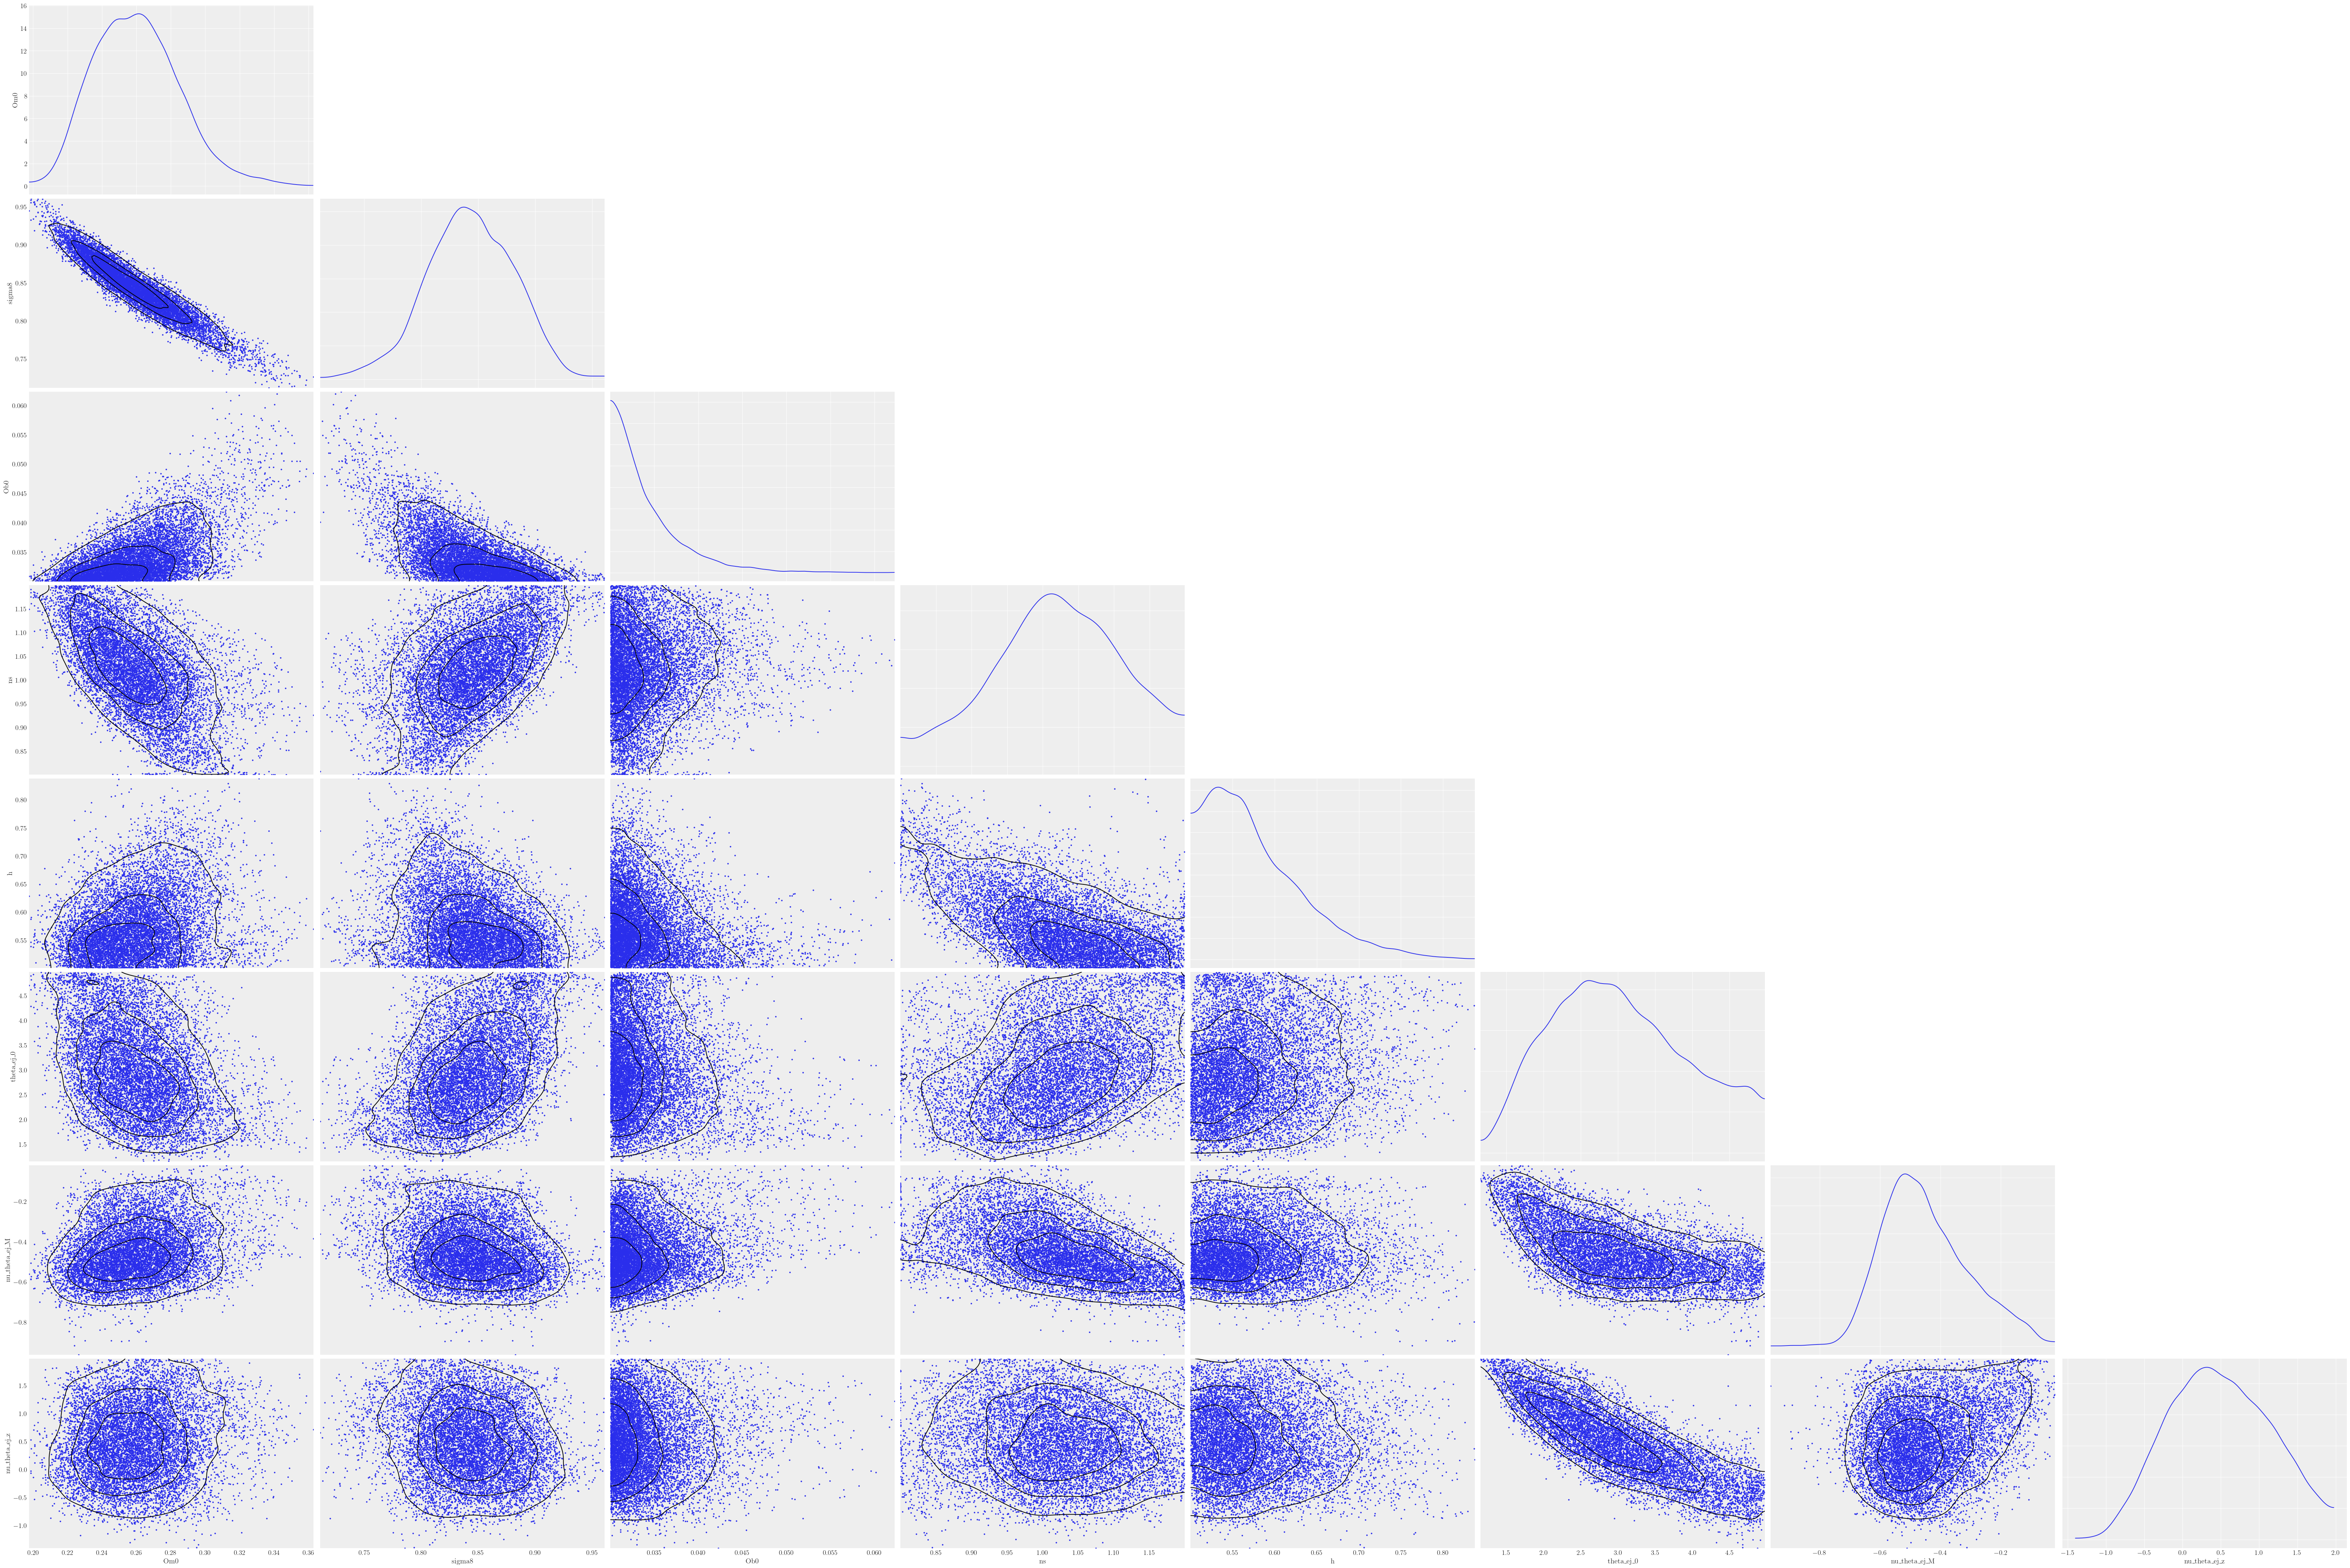

In [19]:
import arviz as az

az.style.use("arviz-darkgrid")

axes = az.plot_pair(
    s,
    kind=["scatter", "kde"],
    # var_names=['Om0', 'sigma8',  'theta_ej_0', 'nu_theta_ej_M', 'nu_theta_ej_z'],
    var_names=['Om0', 'sigma8', 'Ob0', 'ns', 'h', 'theta_ej_0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'A_IA', 'eta_IA'],
    # var_names=['theta_ej_0', 'nu_theta_ej_M', 'nu_theta_ej_z'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
    point_estimate="median",
);

fig = axes.ravel()[0].figure
fig.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/ACTxDES/test_plot_3.png')


In [23]:
import pickle as pk
df = pk.load(open('/mnt/home/spandey/ceph/GODMAX/notebooks/ACTxDES/mcmc_gty_xip_xim_8000_8000_800.pkl','rb'))
# df['s'].shape
# df
samps = []
keys = []
for key in df:
    if 'base' not in key:
        samps.append(df[key])
        keys.append(key)


In [24]:
samps = np.array(samps).T


In [25]:
samp_S8 = samps[:,3] * (samps[:,0]/0.3)**0.5

samps = np.concatenate([samps, samp_S8[:,None]], axis=1)
keys.append('S8')

# samps = np.moveaxis(samps, 3, 1)
# keys = 

samps.shape

(8000, 6)

In [26]:
keys


['Om0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'sigma8', 'theta_ej_0', 'S8']

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [28]:
import getdist
from getdist import plots, MCSamples
# names = ["x%s"%i for i in range(ndim)]
# labels =  ["x_%s"%i for i in range(ndim)]
names = keys
labels = [r'$\Omega_m$', r'$\nu^{M}_{\theta_{\rm ej}}$', r'$\nu^{z}_{\theta_{\rm ej}}$', r'$\sigma_8$', r'$\theta_{\rm ej, 0}$', r'$S_8$']
samples = MCSamples(samples=samps,names = names, labels = labels)


Removed no burn in


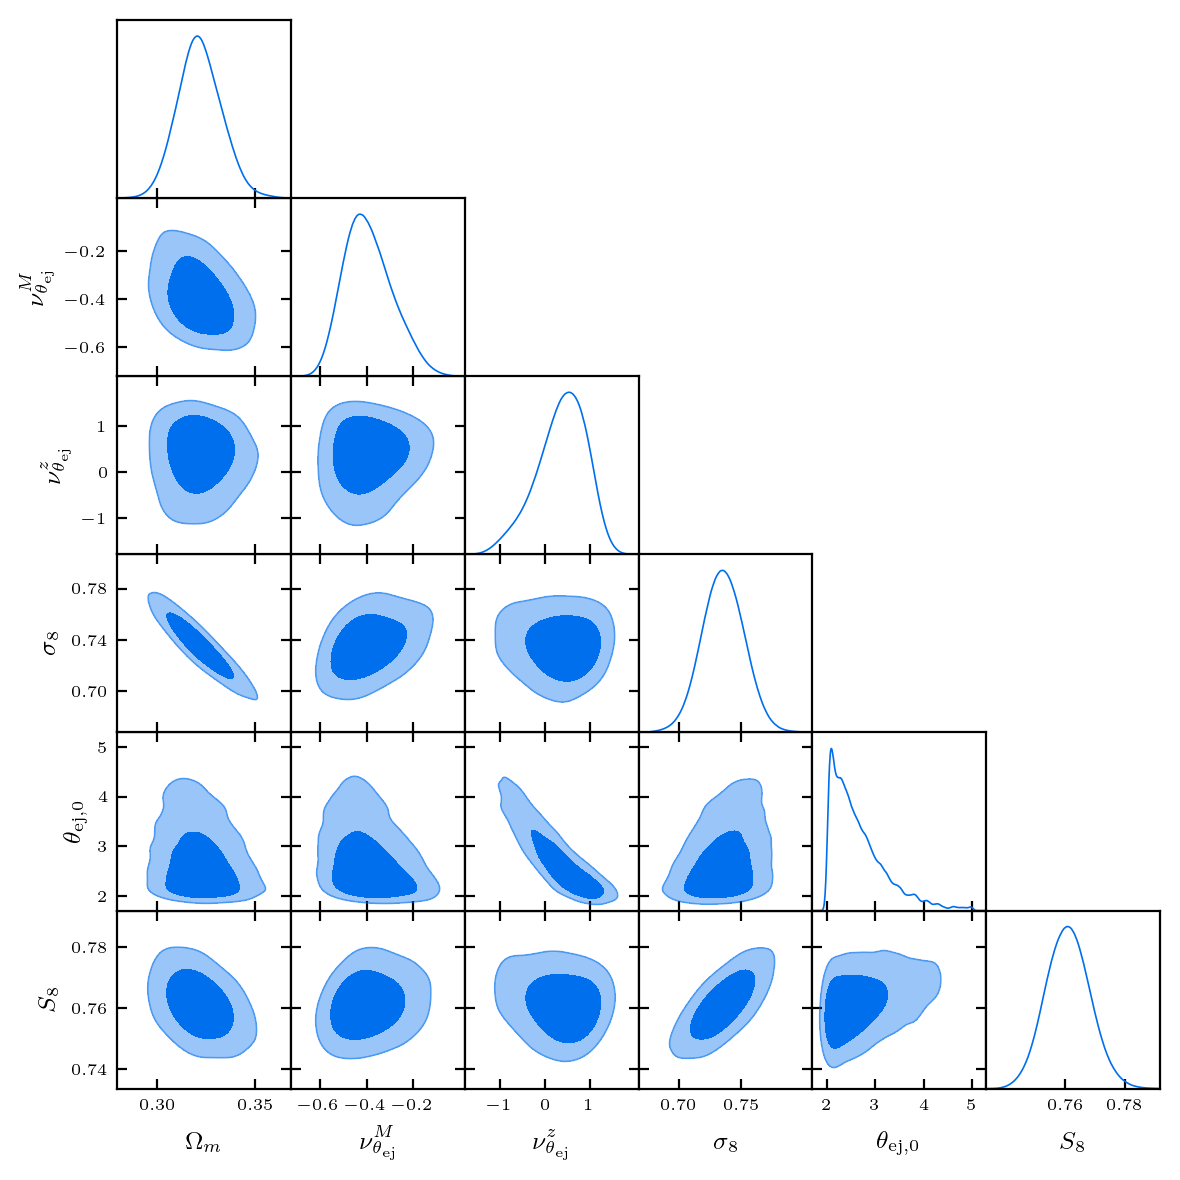

In [29]:
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples], filled=True)
g.export('/mnt/home/spandey/ceph/GODMAX/notebooks/ACTxDES/test_plot_4.pdf')
